# Automatic differentiation with Metamodel EOS

This is essentially the same as `examples/automatic_differentiation.ipynb` (so look at that example for full details), but here using the metamodel EOS rather than metamodel with speed-of-sound extension scheme. 

In [18]:
from typing import Callable
import numpy as np
import matplotlib.pyplot as plt
params = {"text.usetex" : True,
          "font.family" : "serif",
          "font.serif" : ["Computer Modern Serif"],
          "xtick.labelsize": 16,
          "ytick.labelsize": 16,
          "axes.labelsize": 16,
          "legend.fontsize": 16,
          "legend.title_fontsize": 16}
plt.rcParams.update(params)
import matplotlib.cm as cm
import matplotlib.colors as colors

import jax
import jax.numpy as jnp
# jax.config.update("jax_debug_nans", True) # if you hit NaNs, uncomment this line to debug a bit

from jesterTOV.eos.metamodel.metamodel import MetaModel_EOS_model
from jesterTOV.eos.families import construct_family

## EOS and TOV setup

In [19]:
nsat = 0.16 # nuclear saturation density in fm^-3
NMAX_NSAT = 12.0 # maximum density to consider in nsat
NMAX = NMAX_NSAT * nsat # maximum density in fm^-3  
eos = MetaModel_EOS_model(nmax_nsat=NMAX_NSAT)

In [20]:
construct_family_lambda = lambda x: construct_family(x, ndat = 100, min_nsat = 0.5)

In [21]:
def transform_func(params: dict[str, float],
                   fixed_params: dict[str, float]) -> dict[str, float]:
    """
    Auxiliary transformation function that takes in a dict of parameters for the metamodel and speed-of-sound EOS parametrization, and returns the neutron-star family as output.
    
    The idea is that JAX will have to differentiate only with respect to the first argument `params`, and we allow to pass parameters that we do not wish to optimize in the second argument.
    """
    
    # Add any parameters that are fixed and therefore not part of the first argument.
    params.update(fixed_params)
        
    # Create the EOS, ignore mu and cs2 (final 2 outputs)
    ns, ps, hs, es, dloge_dlogps, _, _ = eos.construct_eos(params)
    eos_tuple = (ns, ps, hs, es, dloge_dlogps)
    
    # Solve the TOV equations
    _, masses_EOS, radii_EOS, Lambdas_EOS = construct_family_lambda(eos_tuple)

    # Choose what to return here:
    return_dict = {"masses_EOS": masses_EOS, "radii_EOS": radii_EOS, "Lambdas_EOS": Lambdas_EOS}
    
    return return_dict

In [22]:
# Choose for an empty dict for the fixed parameters if all are varied:
fixed_params = {}

# Choose to fix some parameters -- here, E_sat and the CSE density grid points
fixed_params["E_sat"] = -16.0
    
print("Fixed params are:")
for key, value in fixed_params.items():
    print(f"    {key}: {value}")

Fixed params are:
    E_sat: -16.0


In [23]:
starting_parameters = {"E_sat": -16.0, # metamodel saturation energy parameters
                       "K_sat": 100.0,
                       "Q_sat": 0.0,
                       "Z_sat": 0.0,
                       "E_sym": 28.0, # metamodel symmetry energy parameters
                       "L_sym": 70.0,
                       "K_sym": 0.0,
                       "Q_sym": 0.0,
                       "Z_sym": 0.0,
                       }

# Remove the fixed parameters from the starting parameters:
for key, value in fixed_params.items():
    if key in starting_parameters:
        del starting_parameters[key]

# Show starting parameters to the user
print("Starting parameters are:")    
for key, value in starting_parameters.items():
    print(f"    {key}: {value}")
print(f"Optimization will be in {len(starting_parameters)} dimensional EOS space.")

Starting parameters are:
    K_sat: 100.0
    Q_sat: 0.0
    Z_sat: 0.0
    E_sym: 28.0
    L_sym: 70.0
    K_sym: 0.0
    Q_sym: 0.0
    Z_sym: 0.0
Optimization will be in 8 dimensional EOS space.


How does our initial guess look like?

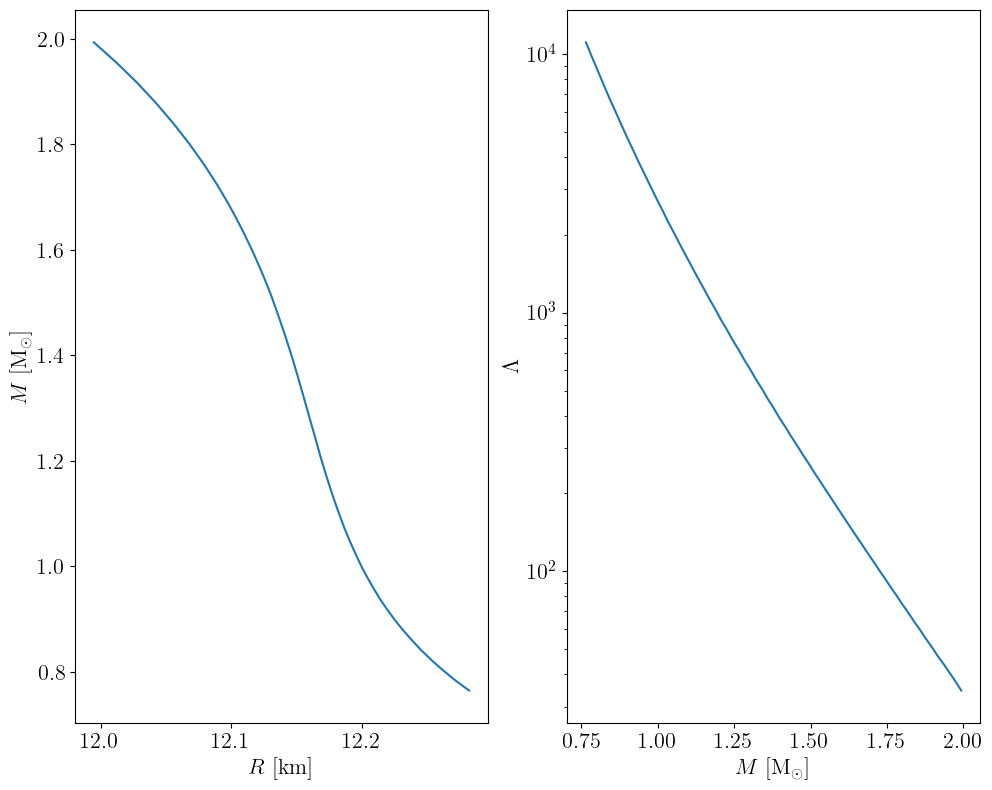

In [24]:
# Solve the TOV equations
out = transform_func(starting_parameters, fixed_params)
m, r, l = out["masses_EOS"], out["radii_EOS"], out["Lambdas_EOS"]

plt.subplots(nrows = 1, ncols = 2, figsize=(10, 8))
mask = m > 0.75
plt.subplot(121)
plt.plot(r[mask], m[mask])
plt.xlabel(r"$R$ [km]")
plt.ylabel(r"$M$ [M$_\odot$]")

plt.subplot(122)
plt.plot(m[mask], l[mask])
plt.xlabel(r"$M$ [M$_\odot$]")
plt.ylabel(r"$\Lambda$")
plt.yscale("log")
plt.tight_layout()
plt.show()
plt.close()

## Score functions

In [25]:
def score_fn_mtov(params: dict[str, float],
                  fixed_params: dict[str, float],
                  sign = -1) -> tuple:
    """
    Score function where the score is the TOV mass of the EOS corresponding to params.
    The sign is used to indicate whether we want to maximize or minimize the score.
    
    Note that we return the output of the TOV solver in the second argument, which JAX will consider as "aux" in `jax.grad`
    """
    
    out = transform_func(params, fixed_params)
    mtov = jnp.max(out["masses_EOS"])
    score = sign * mtov
    return score, out

def score_fn_radius(params: dict[str, float],
                    fixed_params: dict[str, float],
                    sign = +1,
                    target_radius: float = 12.0) -> tuple:
    """
    Score function where the score is the Lambda value at 1.4 Msun of the EOS corresponding to params.
    The sign is used to indicate whether we want to maximize or minimize the score.
    
    Note that we return the output of the TOV solver in the second argument, which JAX will consider as "aux" in `jax.grad`
    """
    
    out = transform_func(params, fixed_params)
    m, r = out["masses_EOS"], out["radii_EOS"]
    R14 = jnp.interp(1.4, m, r)
    score = sign * jnp.abs(R14 - target_radius)
    return score, out

# Optimizer setup

Let us now define the master function that performs several loops of gradient descent with a given learning rate (step size).

Note: to make use of the Adam optimizer, we will use functions from `optax`, which is a library for gradient-based optimization in `JAX`. We also use `tqdm` for a nice progress bar. These are not in the requirements when installing `jester` (since the core functionality does not require it), so you will need to install it separately if you want to run this notebook.

In [26]:
try:
    import optax
    import tqdm
except ImportError:
    raise ImportError("optax and tqdm is not installed. Please install it with 'pip install optax' for this notebook.")

In [27]:
def run(score_fn: Callable,
        starting_parameters: dict[str, float],
        fixed_params: dict[str, float],
        sign: int = -1, 
        nb_steps: int = 200,
        learning_rate: float = 1e-3,):
    
    print("Computing by gradient ascent . . .")
    pbar = tqdm.tqdm(range(nb_steps))
    
    # Define the score function with gradient applied to it. We only differentiate with respect to the first argument.
    score_fn_with_sign = lambda params, fixed_params: score_fn(params, fixed_params, sign)
    score_fn_with_grad = jax.jit(jax.value_and_grad(score_fn_with_sign, argnums=0, has_aux=True))
    
    # Will store the results per iteration in a dict
    trajectory = {}
    params = starting_parameters.copy()
    
    # Initialize the optimizer
    gradient_transform = optax.adam(learning_rate=learning_rate)
    opt_state = gradient_transform.init(params)
    
    for i in pbar:
        ((score, aux), grad) = score_fn_with_grad(params, fixed_params)
        m, r, l = aux["masses_EOS"], aux["radii_EOS"], aux["Lambdas_EOS"]
        
        # Check for NaNs
        if np.any(np.isnan(m)) or np.any(np.isnan(r)) or np.any(np.isnan(l)):
            print(f"Iteration {i} has NaNs. Exiting the computing loop now")
            
            print("score")
            print(score)
            
            print("grad")
            print(grad)
            
            print("aux")
            print(aux)
            break
        
        pbar.set_description(f"Iteration {i}: score {score}")
            
        # Apply the gradient updates to the parameters
        updates, opt_state = gradient_transform.update(grad, opt_state)
        params = optax.apply_updates(params, updates)
        
        # Enforce no CSE value is above 1 (if needed)
        for key in params.keys():
            if "cs2_CSE" in key:
                params[key] = jnp.clip(params[key], 0, 1)
                
        # Store the results:
        trajectory[i] = {"params": params,
                         "score": score,
                         "masses_EOS": aux["masses_EOS"],
                         "radii_EOS": aux["radii_EOS"],
                         "Lambdas_EOS": aux["Lambdas_EOS"]}
        
    return trajectory

## Runs

Here is a simple plotting script to plot the different iteration results that we can reuse later on

In [28]:
def plot_trajectory(trajectory: dict,
                    plot_score: bool = False):
    """
    Plot the trajectory of the optimization process.
    """
    max_iteration = max(trajectory.keys())
    
    if plot_score:
        plt.figure(figsize=(10, 8))
        plt.plot([trajectory[i]["score"] for i in trajectory.keys()])
        plt.xlabel("Iteration")
        plt.ylabel("Score")
        plt.title("Trajectory of the optimization process")
        plt.show()
        plt.close()
        
    # Prepare color map based on iteration number
    iterations = list(trajectory.keys())
    norm = colors.Normalize(vmin=min(iterations), vmax=max(iterations))
    cmap = cm.viridis
    sm = cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
        
    # Plot the masses and radii
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize=(10, 8))
    for i in trajectory.keys():
        color = cmap(norm(i))

        # M(R)
        plt.subplot(121)
        mask = trajectory[i]["masses_EOS"] > 0.75
        plt.plot(trajectory[i]["radii_EOS"][mask], trajectory[i]["masses_EOS"][mask], color=color)
        
        # Lambda(M)
        plt.subplot(122)
        plt.plot(trajectory[i]["masses_EOS"][mask], trajectory[i]["Lambdas_EOS"][mask], color=color)
      
    plt.subplot(121)
    plt.xlabel(r"$R$ [km]")
    plt.ylabel(r"$M$ [M$_\odot$]")
    
    plt.subplot(122)
    plt.xlabel(r"$M$ [M$_\odot$]")
    plt.ylabel(r"$\Lambda$")
    plt.yscale("log")
    plt.tight_layout()
    
    fig.colorbar(sm, ax=axes.ravel().tolist(), label="Iteration")

Let us now do some runs.
On a CPU (Macbook), the speed seems to be around 5 iterations per second.
Note that the first iteration is slower, since `JAX` has to compile the code.

### Maximizing TOV mass

Computing by gradient ascent . . .


Iteration 99: score -2.0746696738730828: 100%|██████████| 100/100 [00:18<00:00,  5.44it/s]


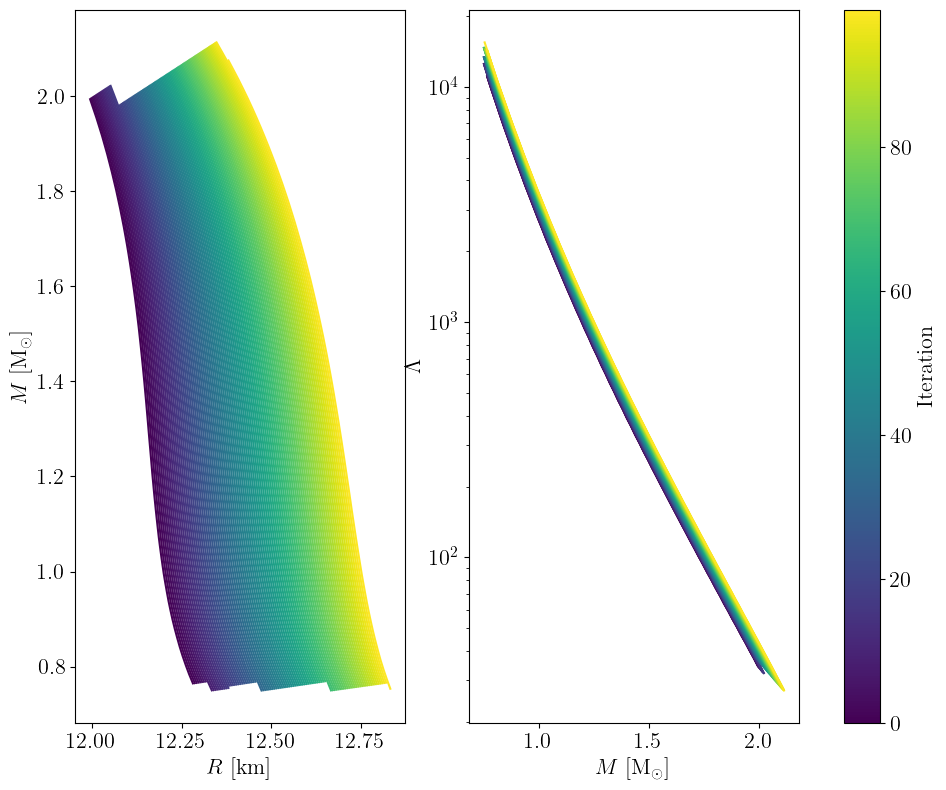

In [29]:
trajectory = run(score_fn_mtov,
                 starting_parameters,
                 fixed_params,
                 sign = -1,
                 nb_steps = 100,
                 learning_rate = 0.1)
plot_trajectory(trajectory)
plt.show()
plt.close()

### Towards target radius at 1.4 solar mass

In [33]:
trajectory = run(score_fn_radius,
                 starting_parameters,
                 fixed_params,
                 sign = +1,
                 nb_steps = 50,
                 learning_rate = 0.1)

Computing by gradient ascent . . .


Iteration 49: score 0.0071626697443232246: 100%|██████████| 50/50 [00:12<00:00,  3.95it/s]


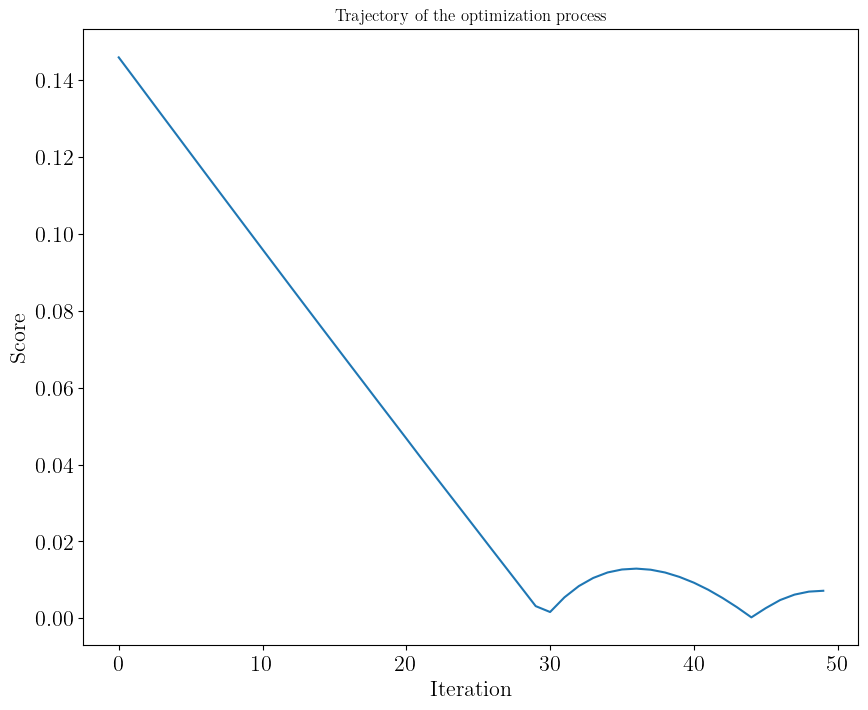

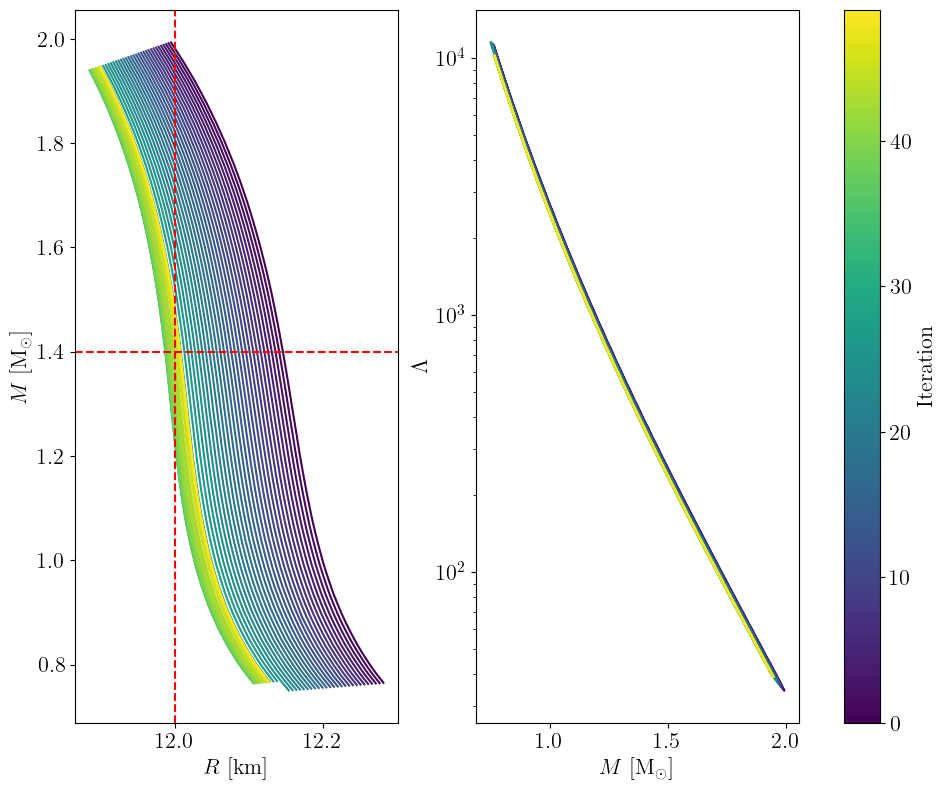

In [34]:
plot_trajectory(trajectory, plot_score = True) # plot_score: to show convergence
plt.subplot(121)
plt.axhline(y=1.4, color='r', linestyle='--')
plt.axvline(x=12.0, color='r', linestyle='--')
plt.show()
plt.close()

### Parameter trajectory

For this final example, let us show the trajectory of the parameters during the optimization process to show that all of them evolve somewhat independently (although some are more correlated than others).

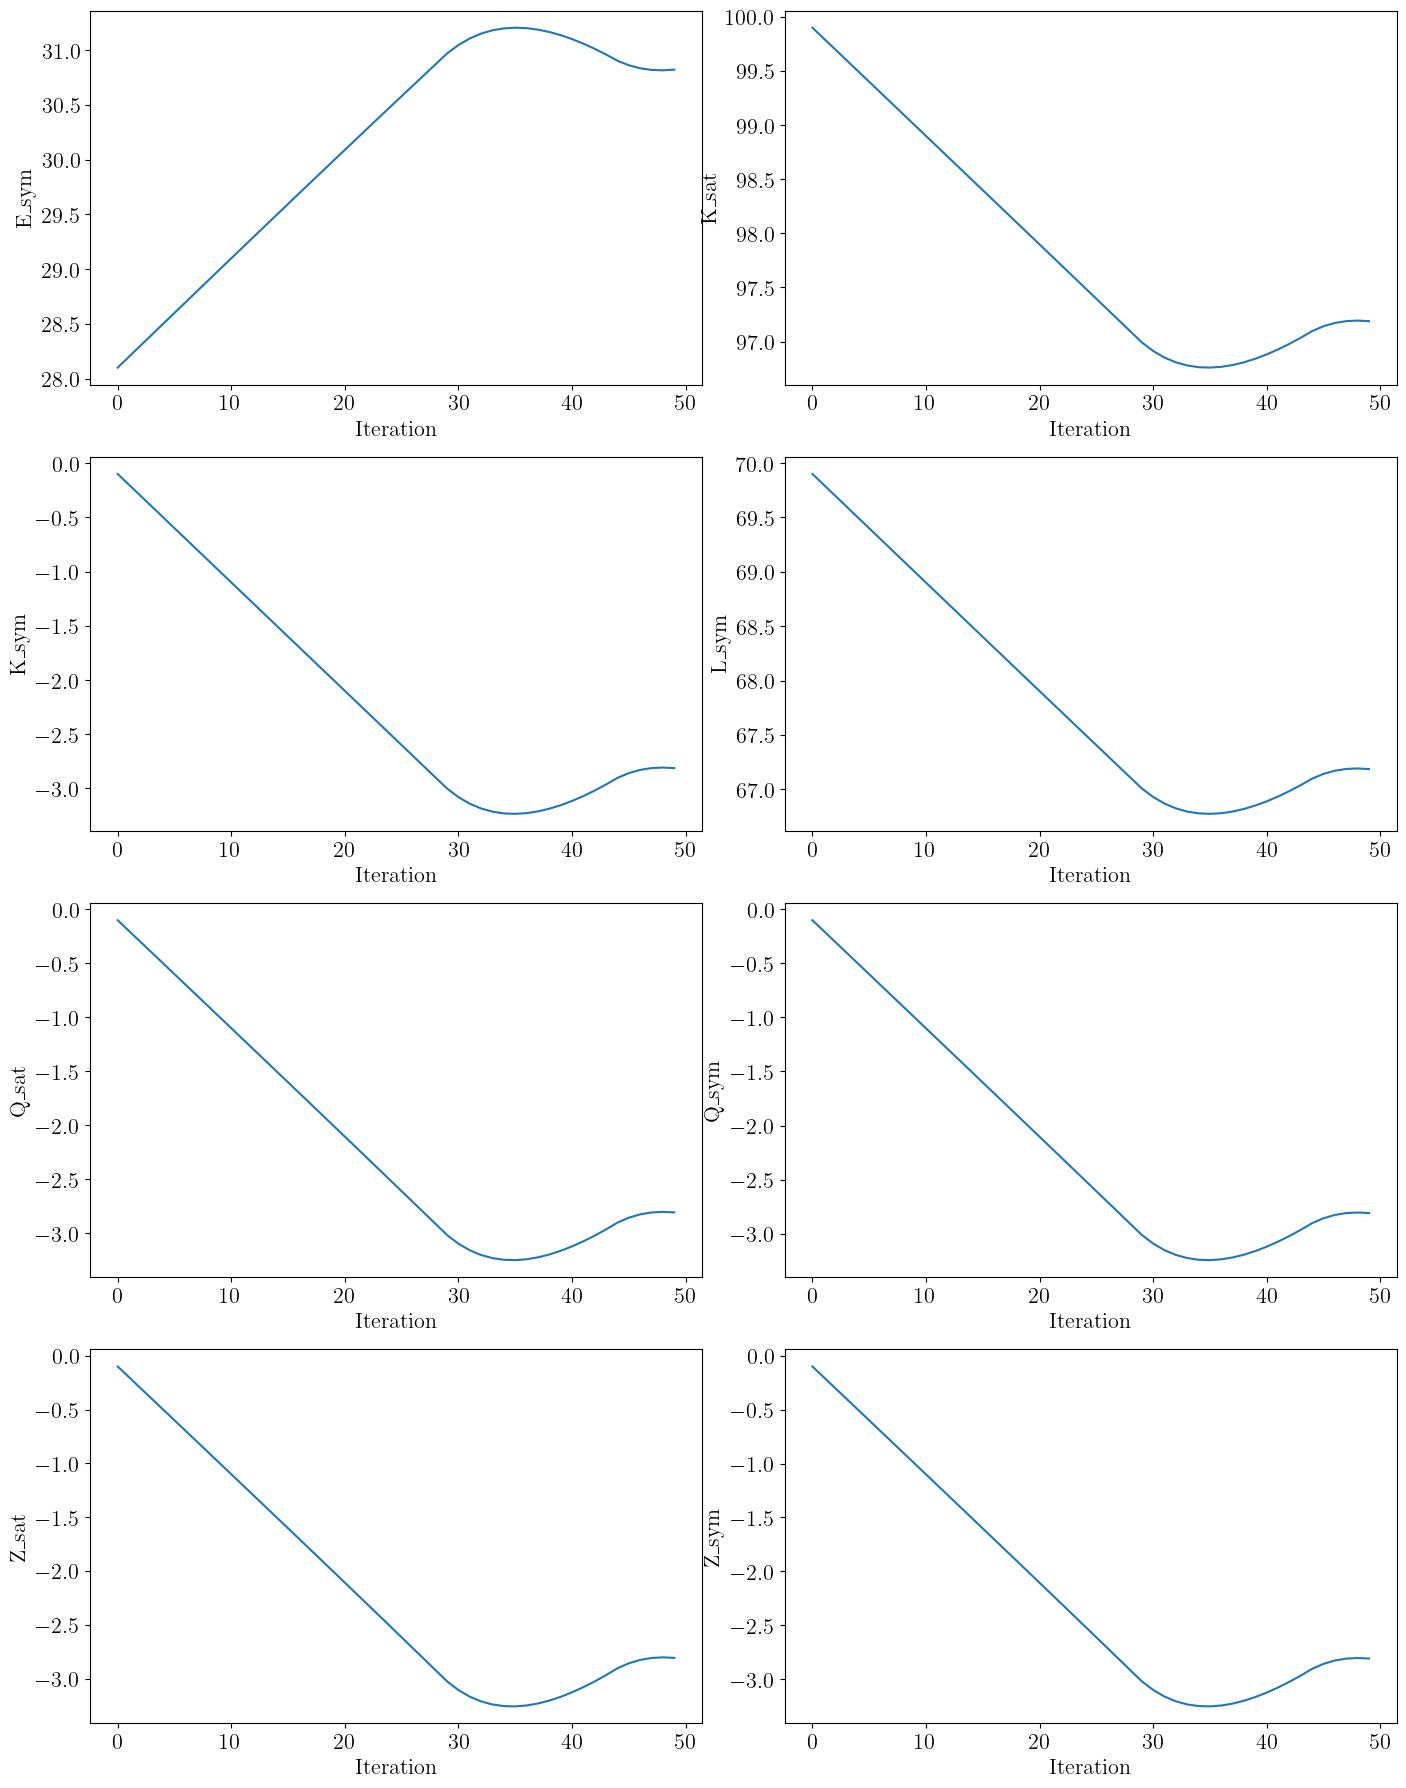

In [35]:
# Get names of parameters that are not fixed
param_names = [name for name in trajectory[0]["params"].keys()
                if name not in fixed_params.keys()]

n_params = len(param_names)
n_rows, n_cols = 4, 2

fig, axes = plt.subplots(n_rows, n_cols, figsize=(14, 18))
axes = axes.flatten()

for idx, name in enumerate(param_names):
    ax = axes[idx]
    ax.plot([trajectory[i]["params"][name] for i in trajectory.keys()])
    ax.set_xlabel("Iteration")
    ax.set_ylabel(name)

# Hide any unused subplots (if fewer than 18)
for j in range(len(param_names), len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()
plt.close()